# Lung Segementation Using Deep Learning (UNet)

## Importing dataset from kaggle for training

In [0]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!echo '{"username":"","key":""}' >> ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.56G/9.58G [03:48<00:00, 75.4MB/s]
100% 9.58G/9.58G [03:49<00:00, 44.9MB/s]


In [0]:
!unzip chest-xray-masks-and-labels.zip

In [0]:
!rm -r data

In [0]:
!mv Lung\ Segmentation lung

In [0]:
!rm chest-xray-masks-and-labels.zip

## Preprocessing dataset for training

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
import os
import random
import re
from PIL import Image

In [0]:
DATA_PATH = '/content/lung'
FRAME_PATH = DATA_PATH+'/CXR_png'
MASK_PATH = DATA_PATH+'/masks'

In [0]:
images = os.listdir(FRAME_PATH)
mask = os.listdir(MASK_PATH)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [0]:
check = [i for i in mask if "mask" in i]

In [9]:
len(check)

566

In [10]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
testing_files = set(os.listdir(FRAME_PATH)) & set(os.listdir(MASK_PATH))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(FRAME_PATH,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(MASK_PATH,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(FRAME_PATH,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(MASK_PATH,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [0]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [13]:
dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [00:45<00:00,  3.27it/s]


## Visualising Dataset

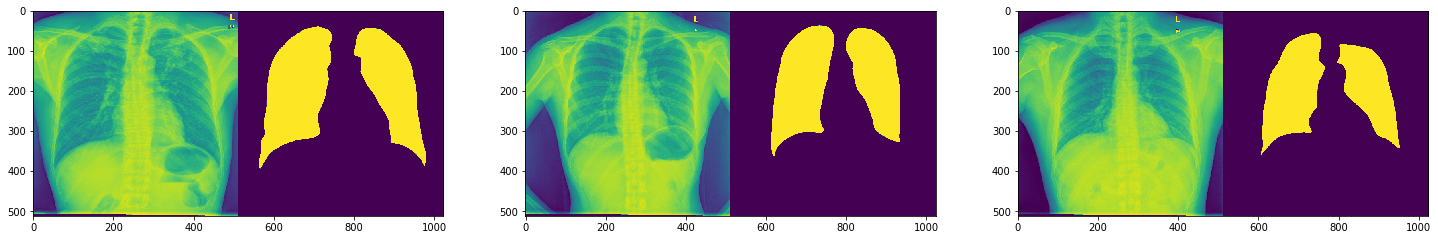

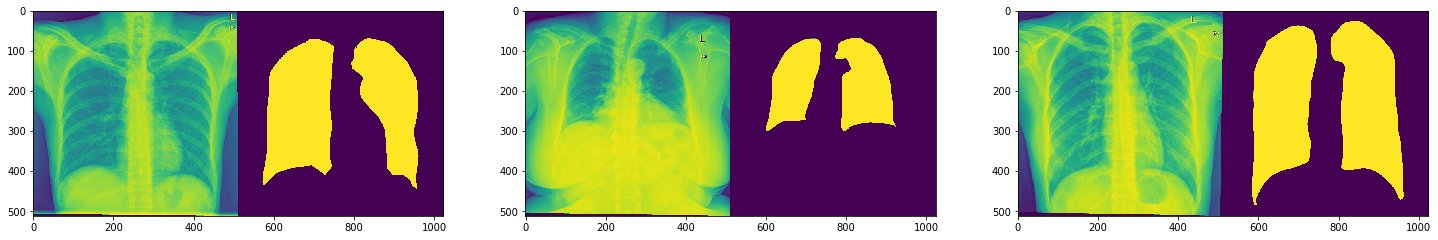

In [14]:
plotMask(X_train,y_train)

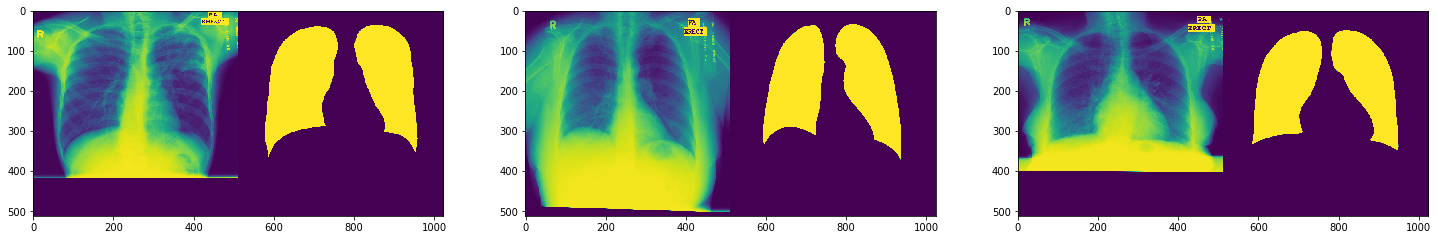

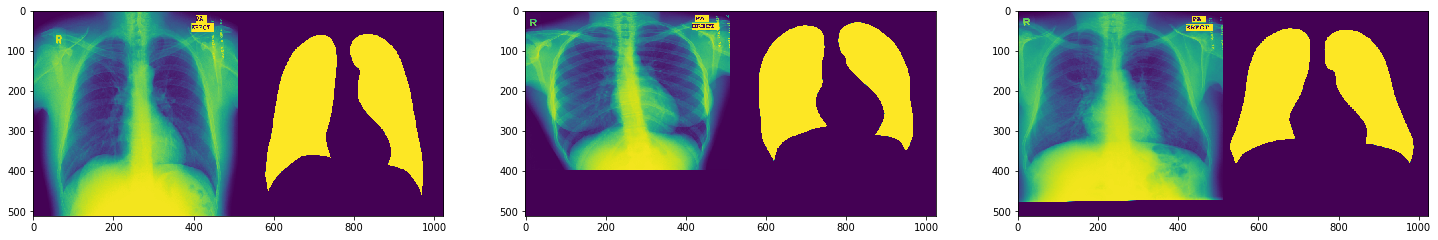

In [15]:
plotMask(X_test,y_test)

In [0]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

## Defining Model (UNet) and Callbacks

In [0]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [119]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [120]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Training the model

In [0]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 8,
                  epochs = 20,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)


clear_output()

## Plot the metrics and evaluate

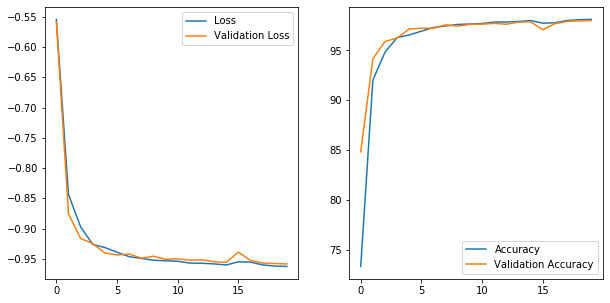

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

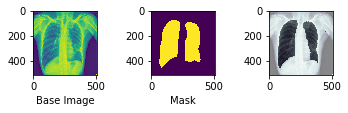

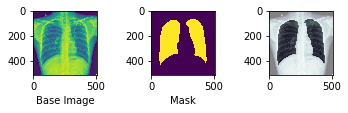

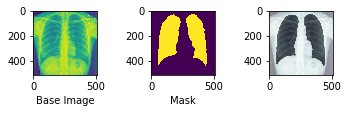

In [123]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

# plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap="bone")
    plt.imshow(np.squeeze(preds[pred_candidates[i]]), alpha=0.5, cmap="bone_r")
    plt.show()
    
    # plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    # plt.xlabel("Pridiction")

In [124]:
pred_candidates

array([68, 19, 12, 51, 65, 42, 70, 37, 30,  2])

In [125]:
validation_vol[0].shape

(512, 512, 1)

In [0]:
img_path = "/content/lung/CXR_png/CHNCXR_0002_0.png"

In [0]:
X_shape = 256*2

In [0]:
x_im = cv2.resize(cv2.imread(img_path),(X_shape,X_shape))[:,:,0]

In [129]:
x_im.reshape(1, x_im.shape[0], x_im.shape[1], 1).shape

(1, 512, 512, 1)

In [130]:
x_im.shape

(512, 512)

In [0]:
op = model.predict((x_im.reshape(1, 512, 512, 1)-127.0)/127.0)
# op = model.predict(np.array([validation_vol[0]]))

In [132]:
op.shape

(1, 512, 512, 1)

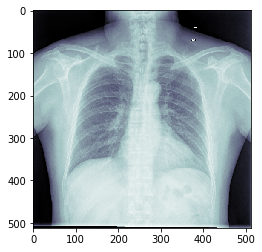

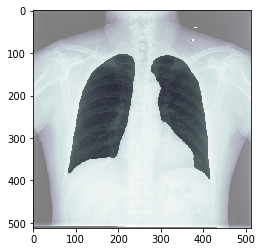

In [133]:
plt.imshow(x_im, cmap="bone", label="Input Image")
plt.show()

plt.imshow(x_im, cmap="bone", label="Output Image")
plt.imshow(op.reshape(512, 512), alpha=0.5, cmap="bone_r")
plt.show()

## Importing the given data in task to check if it is working with that

In [0]:
URL = "https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip"

In [66]:
!wget $URL

--2020-03-04 16:54:59--  https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
Resolving data.mendeley.com (data.mendeley.com)... 104.18.15.189, 104.18.14.189, 2606:4700::6812:fbd, ...
Connecting to data.mendeley.com (data.mendeley.com)|104.18.15.189|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2020-03-04 16:55:01--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.56.184
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.56.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512464 (1

In [0]:
!unzip /content/ChestXRay2017.zip

In [0]:
!rm -r __MACOSX

In [0]:
im_path = "/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg"

In [0]:
x_im = cv2.resize(cv2.imread(img_path),(X_shape,X_shape))[:,:,0]

In [0]:
op = model.predict((x_im.reshape(1, 512, 512, 1)-127.0)/127.0)

In [139]:
op.shape

(1, 512, 512, 1)

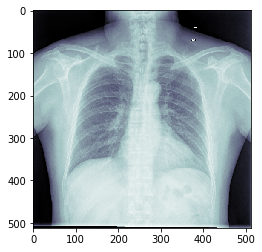

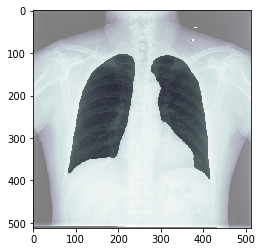

In [140]:
plt.imshow(x_im, cmap="bone", label="Input Image")
plt.show()

plt.imshow(x_im, cmap="bone", label="Output Image")
plt.imshow(op.reshape(512, 512), alpha=0.5, cmap="bone_r")
plt.show()

## Saving the model

In [0]:
model.save('model.h5')

In [0]:
!cp model.h5 drive/My\ Drive/xray